This script attempts to download yahoo finance stock data. In particular:
1. Historical Ticker - complete
2. Statistics - complete
3. Income Statement - complete
4. Balance Sheet - complete
5. Cash Flows - complete
6. Holders - complete

In [1]:
import re
import os
import json
import csv
from io import StringIO
#from bs4 import BeautifulSoup
import requests
import pandas as pd
from requests import Session

SESSION = Session()
%config Completer.use_jedi = False

In [2]:
monthly_dir = "Monthly Stock Data/"
os.makedirs(monthly_dir, exist_ok=True)

In [3]:
r = requests.Session()

In [4]:
stock = 'ZST.TO'
url = "https://query1.finance.yahoo.com/v7/finance/download/{}"


params = {
    
    'range': 'max', #max
    'interval':'1mo',
    'events':'history'
    
    
    
}


"""
Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]'
"""

# Get
result = r.get(url.format(stock), params = params)
# Format
csv = StringIO(result.text)
# DataFrame
df = pd.read_csv(csv)
# To csv
df.to_csv(monthly_dir + stock + '.csv')

df

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2


### Load all ETFs listed on TSX

In [ ]:
etfs = pd.read_csv("TSX ETF TICKERS.csv")
#etfs["Parsed"] = 0
etfs

#### Loop through all ETFs and download monthly data

In [ ]:
### Todo: for x in INDEX of unparsed_etfs loop through etfs

unparsed_etfs = etfs.loc[etfs["Parsed"] < 1]

for i in unparsed_etfs.index:
    
    try: 
        ticker = etfs.iloc[i][0] # get the ticker from original list
        

        stock = f'{ticker}.TO'
        url = "https://query1.finance.yahoo.com/v7/finance/download/{}"


        params = {

            'range': 'max', 
            'interval':'1mo',
            'events':'history'
        }


        # Get
        r = requests.get(url.format(stock), params = params)
        # Format
        print(r.response)
        csv = StringIO(r.text)
        # DataFrame
        df = pd.read_csv(csv)
        # To csv
        df.to_csv(monthly_dir + stock + '.csv')
        print("got",ticker)
        
        # Record Parsed
        etfs.at[i, "Parsed"] = 1
        
    except:
        continue

In [ ]:
etfs.to_csv("TSX ETF TICKERS.csv", index=False)

In [ ]:
etfs

## 2. Statistics

In [ ]:
stock = 'stock'
url = f"https://finance.yahoo.com/quote/{stock}/key-statistics?p={stock}"

result = r.get(url)
result

In [ ]:
result.text

In [ ]:
print(url)

In [16]:
import yfinance as yf
ticker = 'MSFT'
stock = yf.Ticker(ticker)

# get stock info
stock.info

{'zip': '98052-6399',
 'sector': 'Technology',
 'fullTimeEmployees': 163000,
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for small and medium businesses, large organizations, and divisions of enterprises. Its Intelligent Cloud segment licenses SQL and Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting services to assist customers in developing, deploying, and managing Microsoft server and de

In [ ]:
stock.financials

In [ ]:
stock.balance_sheet

In [ ]:
stock.earnings

In [ ]:
stock.cashflow

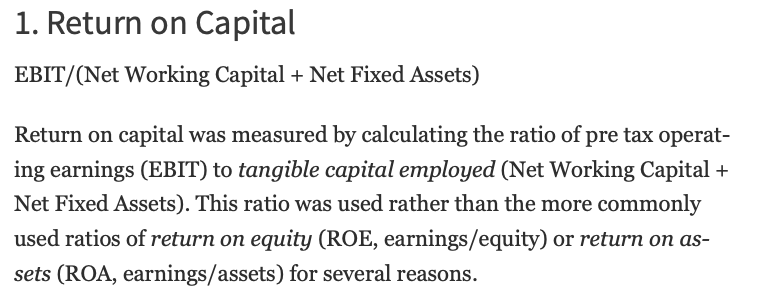

In [ ]:
# Get most recent EBIT
ebit = stock.financials.loc["Ebit"][0]
# Get most recent net tanbile assets
net_tangible_assets = stock.balance_sheet.loc['Net Tangible Assets'][0]

roc = ebit/net_tangible_assets

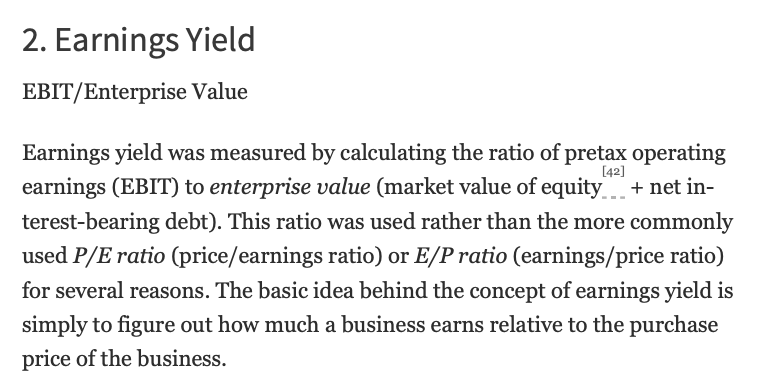

In [ ]:
# Get Enterprise Value
enterprise_value = stock.info["enterpriseValue"]

earnings_yield = ebit/enterprise_value

earnings_yield

In [ ]:
ticker_value = [ticker,roc,earnings_yield]

In [ ]:
ticker_value

## Download US universe of stocks

In [ ]:
nasdaq = 'http://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt'
non_nasdaq = 'http://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt'
# Processed in excel, "|" delimited text, automating this step would be a bonus, not a priority

In [ ]:
df = pd.read_csv("Ticker Lists/Non NASDAQ Tickers.csv")
df

## Update SQL DB

Create connection and tables if they do not exist

In [17]:
import sqlite3
connection = sqlite3.connect("TickerDB.db")
cur = connection.cursor()

cur.execute("CREATE TABLE IF NOT EXISTS NON_NASDAQ (key INTEGER PRIMARY KEY, Ticker TEXT, Security Name TEXT, ROC REAL, EarningsY REAL, Timestamp DATETIME DEFAULT CURRENT_TIMESTAMP)")
cur.execute("CREATE TABLE IF NOT EXISTS NASDAQ (key INTEGER PRIMARY KEY, Ticker TEXT, Security Name TEXT, ROC REAL, EarningsY REAL, Timestamp DATETIME DEFAULT CURRENT_TIMESTAMP )")
cur.execute("CREATE TABLE IF NOT EXISTS TSX (key INTEGER PRIMARY KEY, Ticker TEXT, Security Name TEXT, ROC REAL, EarningsY REAL, Timestamp DATETIME DEFAULT CURRENT_TIMESTAMP )")

connection.commit()

Initialize tables with tickers and names

In [18]:
# NASAQ
df = pd.read_csv("Ticker Lists/NASDAQ Tickers.csv")
values = df[["Symbol","Security Name"]].values
cur.executemany('INSERT OR REPLACE INTO NASDAQ (Ticker, Security) VALUES (?,?)', values)
connection.commit()

In [19]:
# NON NASDAQ
df = pd.read_csv("Ticker Lists/Non NASDAQ Tickers.csv")
values = df[["ACT Symbol","Security Name"]].values
cur.executemany('INSERT OR REPLACE INTO NON_NASDAQ (Ticker, Security) VALUES (?,?)', values)
connection.commit()

In [20]:
# TSX
# Todo

In [ ]:
def get_greenblatt(exchange: str):
    """
    Calculate ROC and Earnings Yield for selected exchange
    exchange: "NASDAQ","Non NASDAQ",todo: "TSX"
    Pulls from SQL DB all tickers missing ROC/EY field
    Or, updates sequentially from oldest timestamp to newest
    """
    
    # step 1 pull ticker list from db
    
    unparsed = get_blank_greenblatts(exchange)
    
    for tickers in unparsed:
        
        ticker = tickers[0]
        print(ticker)
        try:
            # step 2 call helper function to calculate ratios

            greenblatt_ratios =calculate_greenblatt(ticker)

            # step 3 write to sql

            write_greenblatts(greenblatt_ratios, exchange)
    
        except:
            print(f" {ticker} is missing some info \033[1;32;40m SKIP!\033[0;37;40m")

In [22]:
def calculate_greenblatt(ticker: str):
    """
    Given stock ticker as string, pull data from yfinance, calculate ROC/Earnings Yield
    Returns: List [ticker, ROC, Earnings Yield]
    """
    stock = yf.Ticker(ticker, session = SESSION) #persistent session not tested yet
 
    # ROC
    ebit = stock.financials.loc["Ebit"][0]
    net_tangible_assets = stock.balance_sheet.loc['Net Tangible Assets'][0]
    roc = ebit/net_tangible_assets


    #Earnings Yield
    enterprise_value = stock.info["enterpriseValue"]
    earnings_yield = ebit/enterprise_value
    earnings_yield
    
    
    return [ticker,roc,earnings_yield]
    
    

In [23]:
calculate_greenblatt("AAPL")

['AAPL', 1.0145242504476653, 0.028859649430342155]

In [24]:
def get_blank_greenblatts(exchange: str):
    """
    Gets the tickers with blank ROC/EY for given exchange
    :param exchange: string "NASDAQ","NON_NASDAQ","TSX"
    :return: returns list of all tickers w/o greenblatt formulas
    """

    cur.execute(f"SELECT Ticker FROM {exchange} WHERE ROC IS NULL")
    
    
    # todo: add column for out dated to conver past days (int) into datetime, and retrieve
    # so user can say, get_blank_greenblatts(days = 50), to update rows with timestamps older than 50 days
    return cur.fetchall()

In [25]:
result = get_blank_greenblatts("NASDAQ")
result[0][0]

'AACQ'

In [26]:
def write_greenblatts(array, exchange):
    """
    Gets list of greenblatts for 1 ticker at a time
    Writes to database
    :array: list of lists containing [Ticker, ROC, Earnings Yield]
    :return: returns list of tuples containing (key,year,gwp,cost)
    """
    ticker = array[0] # note this is a string with string inside "'AACG '"
    roc = array[1]
    ey = array[2]
    
    cur.execute(f"UPDATE {exchange} SET ROC = {roc}, EarningsY = {ey} WHERE Ticker = '{ticker}'")
    connection.commit()
    return

In [ ]:
get_greenblatt("NASDAQ")

AACQ
Damn man, this stock is cursed! It's missing some info
 SKIP!
AACQU
Damn man, this stock is cursed! It's missing some info
 SKIP!
AACQW
Damn man, this stock is cursed! It's missing some info
 SKIP!
AAXJ
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACAH
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACAHU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACAHW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACBAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACEVU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACEVW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACKIT
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACKIU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ACKIW
Damn man, this stock is cursed! It's missing 

ATIF
ATLC
ATLO
ATNF
ATNFW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ATNI
ATNX
ATOM
ATOS
ATRA
ATRC
ATRI
ATRO
ATRS
ATSG
ATSPT
Damn man, this stock is cursed! It's missing some info
 SKIP!
ATSPU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ATSPW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ATVCU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ATVI
ATXI
AUB
AUBAP
AUBN
AUDC
AUPH
AURC
Damn man, this stock is cursed! It's missing some info
 SKIP!
AURCU
Damn man, this stock is cursed! It's missing some info
 SKIP!
AURCW
Damn man, this stock is cursed! It's missing some info
 SKIP!
AUTL
AUTO
AUUD
AUUDW
Damn man, this stock is cursed! It's missing some info
 SKIP!
AUVI
AVAV
AVCO
AVCT
AVCTW
Damn man, this stock is cursed! It's missing some info
 SKIP!
AVDL
AVEO
Damn man, this stock is cursed! It's missing some info
 SKIP!
AVGO
AVGOP
AVGR
AVID
AVIR
AVNW
AVO
AVRO
AVT
AVXL
AWH
AWRE
AXAS
AXDX
AXGN
AXLA
AXNX
AXON
AXSM
AXTI
AY
AYLA
AYR

Damn man, this stock is cursed! It's missing some info
 SKIP!
BSMU
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSPE
BSQR
BSRR
BSVN
BSY
BTAI
BTAQ
BTAQU
Damn man, this stock is cursed! It's missing some info
 SKIP!
BTAQW
Damn man, this stock is cursed! It's missing some info
 SKIP!
BTBT
BTEC
Damn man, this stock is cursed! It's missing some info
 SKIP!
BTNB
BTRS
BTRSW
Damn man, this stock is cursed! It's missing some info
 SKIP!
BTWN
BTWNU
Damn man, this stock is cursed! It's missing some info
 SKIP!
BTWNW
Damn man, this stock is cursed! It's missing some info
 SKIP!
BUG
Damn man, this stock is cursed! It's missing some info
 SKIP!
BUSE
BVS
BVXV
BWAC
Damn man, this stock is cursed! It's missing some info
 SKIP!
BWACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
BWACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
BWAY
BWB
BWEN
BWFG
BWMX
BXRX
BYFC
BYND
BYSI
BYTSU
Damn man, this stock is cursed! It's missing some info
 SKIP!
BZUN
CAAS
CABA


CRKN
CRMD
CRMT
CRNC
CRNT
CRNX
CRON
CROX
CRSA
CRSAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
CRSAW
Damn man, this stock is cursed! It's missing some info
 SKIP!
CRSP
CRSR
CRTD
CRTDW
Damn man, this stock is cursed! It's missing some info
 SKIP!
CRTO
CRTX
CRUS
CRVL
CRVS
CRWD
CRWS
CRZNU
Damn man, this stock is cursed! It's missing some info
 SKIP!
CSA
Damn man, this stock is cursed! It's missing some info
 SKIP!
CSB
Damn man, this stock is cursed! It's missing some info
 SKIP!
CSBR
CSCO
CSCW
CSF
Damn man, this stock is cursed! It's missing some info
 SKIP!
CSGP
CSGS
CSII
CSIQ
CSML
Damn man, this stock is cursed! It's missing some info
 SKIP!
CSOD
CSPI
CSQ
CSSE
CSSEN
Damn man, this stock is cursed! It's missing some info
 SKIP!
CSSEP
CSTE
CSTL
CSTR
CSWC
CSWI
CSX
CTAQ
CTAQU
Damn man, this stock is cursed! It's missing some info
 SKIP!
CTAQW
Damn man, this stock is cursed! It's missing some info
 SKIP!
CTAS
CTBI
CTEC
Damn man, this stock is cursed! It's missing some info


Damn man, this stock is cursed! It's missing some info
 SKIP!
EKSO
ELDN
ELOX
ELSE
ELTK
ELYS
EM
EMB
Damn man, this stock is cursed! It's missing some info
 SKIP!
EMCB
Damn man, this stock is cursed! It's missing some info
 SKIP!
EMCF
EMIF
Damn man, this stock is cursed! It's missing some info
 SKIP!
EMKR
EML
EMXC
Damn man, this stock is cursed! It's missing some info
 SKIP!
EMXF
Damn man, this stock is cursed! It's missing some info
 SKIP!
ENDP
ENFA
ENFAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ENFAW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ENG
ENLV
ENNV
ENNVU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ENNVW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ENOB
ENPH
ENSG
ENTA
ENTG
ENTX
ENTXW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ENVB
ENVI
ENVIU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ENVIW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ENZL
Damn man, th

FOXA
FOXF
FOXW
FOXWU
Damn man, this stock is cursed! It's missing some info
 SKIP!
FOXWW
Damn man, this stock is cursed! It's missing some info
 SKIP!
FPA
Damn man, this stock is cursed! It's missing some info
 SKIP!
FPAY
FPXE
Damn man, this stock is cursed! It's missing some info
 SKIP!
FPXI
Damn man, this stock is cursed! It's missing some info
 SKIP!
FRAF
FRBA
FRBK
FREE
FREEW
Damn man, this stock is cursed! It's missing some info
 SKIP!
FREQ
FRG
FRGAP
FRGI
FRHC
FRLN
FRME
FROG
FRONU
Damn man, this stock is cursed! It's missing some info
 SKIP!
FRPH
FRPT
FRSG
Damn man, this stock is cursed! It's missing some info
 SKIP!
FRSGU
Damn man, this stock is cursed! It's missing some info
 SKIP!
FRSGW
Damn man, this stock is cursed! It's missing some info
 SKIP!
FRST
FRSX
Damn man, this stock is cursed! It's missing some info
 SKIP!
FRTA
FRWAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
FSBW
FSEA
FSFG
FSII
FSLR
FSRV
FSRVU
Damn man, this stock is cursed! It's missing some info

Damn man, this stock is cursed! It's missing some info
 SKIP!
GNCA
GNFT
GNLN
GNMA
Damn man, this stock is cursed! It's missing some info
 SKIP!
GNOG
GNOM
Damn man, this stock is cursed! It's missing some info
 SKIP!
GNPX
GNRS
GNRSU
Damn man, this stock is cursed! It's missing some info
 SKIP!
GNRSW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GNSS
GNTX
GNTY
GNUS
GO
GOCO
GOEV
GOEVW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GOGL
GOGO
GOOD
GOODM
GOODN
GOOG
GOOGL
GOSS
GOVX
GOVXW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GP
GPAC
GPACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
GPACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GPP
GPRE
GPRO
GRAY
GRBK
GRCL
GRCY
GRCYU
Damn man, this stock is cursed! It's missing some info
 SKIP!
GRCYW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GRFS
GRID
Damn man, this stock is cursed! It's missing some info
 SKIP!
GRIL
GRIN
GRMN
GRNQ
GRNV
GRNVR
Damn

IDRA
IDXX
IDYA
IEA
IEAWW
Damn man, this stock is cursed! It's missing some info
 SKIP!
IEC
IEF
Damn man, this stock is cursed! It's missing some info
 SKIP!
IEI
Damn man, this stock is cursed! It's missing some info
 SKIP!
IEP
IESC
IEUS
Damn man, this stock is cursed! It's missing some info
 SKIP!
IFBD
IFGL
Damn man, this stock is cursed! It's missing some info
 SKIP!
IFMK
IFRX
IFV
Damn man, this stock is cursed! It's missing some info
 SKIP!
IGAC
IGACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
IGACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
IGF
Damn man, this stock is cursed! It's missing some info
 SKIP!
IGIB
Damn man, this stock is cursed! It's missing some info
 SKIP!
IGIC
IGICW
Damn man, this stock is cursed! It's missing some info
 SKIP!
IGMS
IGNY
IGNYU
Damn man, this stock is cursed! It's missing some info
 SKIP!
IGNYW
Damn man, this stock is cursed! It's missing some info
 SKIP!
IGOV
Damn man, this stock is cursed! It's missing some info


KVSA
Damn man, this stock is cursed! It's missing some info
 SKIP!
KVSB
Damn man, this stock is cursed! It's missing some info
 SKIP!
KVSC
Damn man, this stock is cursed! It's missing some info
 SKIP!
KXIN
KYMR
KZIA
KZR
LABP
LACQ
LACQU
LACQW
Damn man, this stock is cursed! It's missing some info
 SKIP!
LAKE
LAMR
LANC
LAND
LANDM
LANDO
LARK
LASR
LATN
LATNU
LATNW
Damn man, this stock is cursed! It's missing some info
 SKIP!
LAUR
LAWS
LAZR
LAZY
LBAI
LBC
LBPH
LBPS
LBPSW
Damn man, this stock is cursed! It's missing some info
 SKIP!
LBRDA
LBRDK
LBRDP
LBTYA
LBTYB
LBTYK
LCAAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
LCAHU
Damn man, this stock is cursed! It's missing some info
 SKIP!
LCAP
LCAPU
Damn man, this stock is cursed! It's missing some info
 SKIP!
LCAPW
Damn man, this stock is cursed! It's missing some info
 SKIP!
LCNB
LCUT
LCY
LCYAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
LCYAW
Damn man, this stock is cursed! It's missing some info
 SKIP!
LDEM


MTC
MTCH
MTCR
MTEM
MTEX
MTLS
MTP
MTRX
MTSI
MTSL
MU
MUDS
MUDSU
MUDSW
Damn man, this stock is cursed! It's missing some info
 SKIP!
MVBF
MVIS
MWK
MXIM
MYFW
MYGN
MYMD
MYRG
MYSZ
MYT
NAAC
NAACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
NAACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
NAII
NAKD
NAOV
NARI
NATH
NATI
NATR
NAVI
NBEV
NBIX
NBLX
NBN
NBRV
NBSE
NBST
Damn man, this stock is cursed! It's missing some info
 SKIP!
NBSTU
Damn man, this stock is cursed! It's missing some info
 SKIP!
NBSTW
Damn man, this stock is cursed! It's missing some info
 SKIP!
NBTB
NBTX
NCBS
NCMI
NCNA
Damn man, this stock is cursed! It's missing some info
 SKIP!
NCNO
NCSM
NCTY
NDAC
NDACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
NDACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
NDAQ
NDLS
NDRA
NDRAW
Damn man, this stock is cursed! It's missing some info
 SKIP!
NDSN
NEBC
NEBCU
Damn man, this stock is cursed! It's missing some info
 SKIP!
NEBCW

Damn man, this stock is cursed! It's missing some info
 SKIP!
PHAR
PHAS
PHAT
PHCF
PHIC
PHICU
Damn man, this stock is cursed! It's missing some info
 SKIP!
PHICW
Damn man, this stock is cursed! It's missing some info
 SKIP!
PHIO
PHIOW
Damn man, this stock is cursed! It's missing some info
 SKIP!
PHO
Damn man, this stock is cursed! It's missing some info
 SKIP!
PHUN
PHUNW
Damn man, this stock is cursed! It's missing some info
 SKIP!
PHVS
PI
PID
Damn man, this stock is cursed! It's missing some info
 SKIP!
PIE
Damn man, this stock is cursed! It's missing some info
 SKIP!
PINC
PIO
Damn man, this stock is cursed! It's missing some info
 SKIP!
PIRS
PIXY
PIZ
Damn man, this stock is cursed! It's missing some info
 SKIP!
PKBK
PKOH
PKW
Damn man, this stock is cursed! It's missing some info
 SKIP!
PLAB
PLAY
PLBC
PLBY
PLCE
PLIN
PLL
PLMIU
Damn man, this stock is cursed! It's missing some info
 SKIP!
PLMR
PLPC
PLRX
PLSE
PLTK
PLUG
PLUS
PLW
Damn man, this stock is cursed! It's missing some info
 SKIP!

Damn man, this stock is cursed! It's missing some info
 SKIP!
RILYL
RILYM
Damn man, this stock is cursed! It's missing some info
 SKIP!
RILYN
Damn man, this stock is cursed! It's missing some info
 SKIP!
RILYO
Damn man, this stock is cursed! It's missing some info
 SKIP!
RILYP
RILYT
Damn man, this stock is cursed! It's missing some info
 SKIP!
RING
Damn man, this stock is cursed! It's missing some info
 SKIP!
RIOT
RIVE
RKDA
RLAY
RLMD
RMBI
RMBL
RMBS
RMCF
RMGB
RMGBU
Damn man, this stock is cursed! It's missing some info
 SKIP!
RMGBW
Damn man, this stock is cursed! It's missing some info
 SKIP!
RMGC
Damn man, this stock is cursed! It's missing some info
 SKIP!
RMGCU
Damn man, this stock is cursed! It's missing some info
 SKIP!
RMGCW
Damn man, this stock is cursed! It's missing some info
 SKIP!
RMNI
RMR
RMRM
RMTI
RNA
RNDB
RNDM
Damn man, this stock is cursed! It's missing some info
 SKIP!
RNDV
Damn man, this stock is cursed! It's missing some info
 SKIP!
RNEM
Damn man, this stock is cursed!

Damn man, this stock is cursed! It's missing some info
 SKIP!
SRAX
SRCE
SRCL
SRDX
SRET
Damn man, this stock is cursed! It's missing some info
 SKIP!
SREV
SRGA
SRNE
SRNG
SRNGU
SRNGW
Damn man, this stock is cursed! It's missing some info
 SKIP!
SRPT
SRRA
SRRK
SRSA
SRSAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
SRSAW
Damn man, this stock is cursed! It's missing some info
 SKIP!
SRTS
SSAA
SSAAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
SSAAW
Damn man, this stock is cursed! It's missing some info
 SKIP!
SSB
SSBI
SSKN
SSNC
SSNT
SSP
SSPK
SSPKU
Damn man, this stock is cursed! It's missing some info
 SKIP!
SSPKW
Damn man, this stock is cursed! It's missing some info
 SKIP!
SSRM
SSSS
SSTI
SSYS
STAA
STAF
STAY
STBA
STCN
STEP
STFC
STIM
STKL
STKS
STLD
STMP
STND
STNE
STOK
STRA
STRL
STRM
STRO
STRR
STRRP
STRS
STRT
STSA
STTK
STWO
STWOU
Damn man, this stock is cursed! It's missing some info
 SKIP!
STWOW
Damn man, this stock is cursed! It's missing some info
 SKIP!

USMC
Damn man, this stock is cursed! It's missing some info
 SKIP!
USOI
Damn man, this stock is cursed! It's missing some info
 SKIP!
USWS
USWSW
Damn man, this stock is cursed! It's missing some info
 SKIP!
USXF
Damn man, this stock is cursed! It's missing some info
 SKIP!
UTHR
UTMD
UTME
Damn man, this stock is cursed! It's missing some info
 SKIP!
UTSI
UVSP
UXIN
VABK
VACQ
VACQU
Damn man, this stock is cursed! It's missing some info
 SKIP!
VACQW
Damn man, this stock is cursed! It's missing some info
 SKIP!
VALU
VAQC
Damn man, this stock is cursed! It's missing some info
 SKIP!
VBFC
VBIV
VBLT
VBTX
VC
VCEL
VCIT
Damn man, this stock is cursed! It's missing some info
 SKIP!
VCKA
VCKAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
VCKAW
Damn man, this stock is cursed! It's missing some info
 SKIP!
VCLT
Damn man, this stock is cursed! It's missing some info
 SKIP!
VCNX
VCSH
Damn man, this stock is cursed! It's missing some info
 SKIP!
VCTR
VCVC
VCVCU
Damn man, this stock is c

Damn man, this stock is cursed! It's missing some info
 SKIP!
ZGYHW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZI
ZION
ZIONL
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZIONN
ZIONO
ZIONP
ZIOP
ZIXI
ZJZZT
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZKIN
ZLAB
ZM
ZNGA
ZNTE
ZNTEU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZNTEW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZNTL
ZS
ZSAN
ZUMZ
ZVO
ZVZZC
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZVZZT
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZWRK
ZWRKU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZWRKW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZWZZT
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZXYZ.A
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZXZZT
Damn man, this stock is cursed! It's missing some info
 SKIP!
ZY
ZYNE
ZYXI
File Creation Time: 04

AQB
AQMS
AQST
AQWA
Damn man, this stock is cursed! It's missing some info
 SKIP!
ARAV
ARAY
ARBG
ARBGU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ARBGW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ARCB
Damn man, this stock is cursed! It's missing some info
 SKIP!
ARCC
ARCE
ARCT
ARDS
ARDX
AREC
ARGX
ARKO
ARKOW
ARKR
ARLP
ARNA
AROW
ARPO
ARQT
ARRW
ARRWU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ARRWW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ARRY
ARTL
ARTLW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ARTNA
ARTW
ARVL
ARVLW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ARVN
ARWR
ARYA
ARYD
ASAX
ASAXU
Damn man, this stock is cursed! It's missing some info
 SKIP!
ASAXW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ASET
Damn man, this stock is cursed! It's missing some info
 SKIP!
ASLE
ASLEW
ASLN
ASMB
ASML
ASND
ASO
ASPC
ASPCU
Damn man, this stock is cursed! It's missing som

Damn man, this stock is cursed! It's missing some info
 SKIP!
BSCU
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSDE
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSET
BSGM
BSJL
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSJM
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSJN
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSJO
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSJP
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSJQ
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSJR
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSJS
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSML
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSMM
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSMN
Damn man, this stock is cursed! It's missing some info
 SKIP!
BSMO
Damn man, this stock is cursed! It's missing some in

CNOB
CNSL
CNSP
CNST
CNTB
CNTG
CNTY
CNXC
CNXN
COCP
CODA
CODX
COFS
COGT
COHR
COHU
COIN
COKE
COLB
COLI
COLIU
Damn man, this stock is cursed! It's missing some info
 SKIP!
COLIW
Damn man, this stock is cursed! It's missing some info
 SKIP!
COLL
COLM
COMM
COMS
COMSW
Damn man, this stock is cursed! It's missing some info
 SKIP!
COMT
Damn man, this stock is cursed! It's missing some info
 SKIP!
CONE
CONN
CONX
CONXU
Damn man, this stock is cursed! It's missing some info
 SKIP!
CONXW
Damn man, this stock is cursed! It's missing some info
 SKIP!
COOL
COOLU
Damn man, this stock is cursed! It's missing some info
 SKIP!
COOLW
Damn man, this stock is cursed! It's missing some info
 SKIP!
COOP
CORE
CORT
COST
COUP
COVA
COVAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
COVAW
Damn man, this stock is cursed! It's missing some info
 SKIP!
COWN
COWNL
Damn man, this stock is cursed! It's missing some info
 SKIP!
CPHC
CPIX
CPLP
CPRT
CPRX
CPSH
CPSI
CPSS
CPTA
CPTAG
Damn man, this stock is cur

DXYN
DYAI
DYN
DYNT
DZSI
EA
EAC
EACPU
Damn man, this stock is cursed! It's missing some info
 SKIP!
EACPW
Damn man, this stock is cursed! It's missing some info
 SKIP!
EAR
EARS
Damn man, this stock is cursed! It's missing some info
 SKIP!
EAST
EBACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
EBAY
EBC
EBET
EBIX
EBIZ
Damn man, this stock is cursed! It's missing some info
 SKIP!
EBMT
EBON
EBSB
EBTC
ECHO
ECOL
ECOLW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ECOR
ECOW
Damn man, this stock is cursed! It's missing some info
 SKIP!
ECPG
EDAP
EDIT
EDOC
Damn man, this stock is cursed! It's missing some info
 SKIP!
EDRY
EDSA
EDTK
EDTX
Damn man, this stock is cursed! It's missing some info
 SKIP!
EDTXU
Damn man, this stock is cursed! It's missing some info
 SKIP!
EDTXW
Damn man, this stock is cursed! It's missing some info
 SKIP!
EDUC
EDUT
Damn man, this stock is cursed! It's missing some info
 SKIP!
EEFT
EEIQ
EEMA
Damn man, this stock is cursed! It's missing s

FISV
FITB
FITBI
FITBO
FITBP
FIVE
FIVN
FIXD
Damn man, this stock is cursed! It's missing some info
 SKIP!
FIXX
FIZZ
FJP
Damn man, this stock is cursed! It's missing some info
 SKIP!
FKU
Damn man, this stock is cursed! It's missing some info
 SKIP!
FKWL
FLAC
FLACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
FLACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
FLDM
FLEX
FLGT
FLIC
FLIR
FLL
FLMN
FLMNW
Damn man, this stock is cursed! It's missing some info
 SKIP!
FLN
Damn man, this stock is cursed! It's missing some info
 SKIP!
FLNT
FLUX
FLWS
FLXN
FLXS
FMAO
FMB
Damn man, this stock is cursed! It's missing some info
 SKIP!
FMBH
FMBI
FMBIO
FMBIP
FMHI
Damn man, this stock is cursed! It's missing some info
 SKIP!
FMIVU
Damn man, this stock is cursed! It's missing some info
 SKIP!
FMNB
FMTX
FNCB
FNCH
FNHC
FNK
Damn man, this stock is cursed! It's missing some info
 SKIP!
FNKO
FNLC
FNWB
FNX
Damn man, this stock is cursed! It's missing some info
 SKIP!
FNY
Damn man, 

Damn man, this stock is cursed! It's missing some info
 SKIP!
GLBL
Damn man, this stock is cursed! It's missing some info
 SKIP!
GLBLU
Damn man, this stock is cursed! It's missing some info
 SKIP!
GLBLW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GLBS
GLBZ
GLDD
GLDI
Damn man, this stock is cursed! It's missing some info
 SKIP!
GLG
GLHAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
GLMD
GLNG
GLPG
GLPI
GLRE
GLSI
GLSPU
Damn man, this stock is cursed! It's missing some info
 SKIP!
GLTO
GLUU
GLYC
GMAB
GMBL
GMBLW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GMBT
GMBTU
Damn man, this stock is cursed! It's missing some info
 SKIP!
GMBTW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GMDA
GMII
GMIIU
Damn man, this stock is cursed! It's missing some info
 SKIP!
GMIIW
Damn man, this stock is cursed! It's missing some info
 SKIP!
GMLPP
Damn man, this stock is cursed! It's missing some info
 SKIP!
GMTX
GNAC
GNACU
Damn man, this stoc

IAC
IART
IBB
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBBJ
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBCP
IBEX
IBKR
IBOC
IBRX
IBTA
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTB
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTD
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTE
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTF
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTG
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTH
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTI
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTJ
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTK
Damn man, this stock is cursed! It's missing some info
 SKIP!
IBTX
ICAD
ICBK
ICCC
ICCH
ICFI
ICHR
ICLK
ICLN
Damn man, this stock is cursed! It's missing some info
 SKIP!
ICLR
ICMB
ICON
ICPT
ICUI
IDBA
IDCC
IDEX
IDLB
Damn man, t

KINS
KINZ
KINZU
Damn man, this stock is cursed! It's missing some info
 SKIP!
KINZW
Damn man, this stock is cursed! It's missing some info
 SKIP!
KIRK
KLAC
KLAQ
KLAQU
Damn man, this stock is cursed! It's missing some info
 SKIP!
KLAQW
Damn man, this stock is cursed! It's missing some info
 SKIP!
KLDO
KLIC
KLXE
KMDA
KMPH
KNBE
KNDI
KNSA
KNSL
KNTE
KOD
KOPN
KOR
Damn man, this stock is cursed! It's missing some info
 SKIP!
KOSS
KPTI
KRBP
KRKR
KRMA
Damn man, this stock is cursed! It's missing some info
 SKIP!
KRMD
KRNL
KRNLU
Damn man, this stock is cursed! It's missing some info
 SKIP!
KRNLW
Damn man, this stock is cursed! It's missing some info
 SKIP!
KRNT
KRNY
KRON
KROS
KRT
KRTX
KRUS
KRYS
KSICU
Damn man, this stock is cursed! It's missing some info
 SKIP!
KSMT
KSMTU
Damn man, this stock is cursed! It's missing some info
 SKIP!
KSMTW
Damn man, this stock is cursed! It's missing some info
 SKIP!
KSPN
KTCC
KTOS
KTRA
KURA
KURI
KURIU
Damn man, this stock is cursed! It's missing some info
 SKIP!

Damn man, this stock is cursed! It's missing some info
 SKIP!
MOR
MORF
MORN
MOSY
MOTN
MOTNU
Damn man, this stock is cursed! It's missing some info
 SKIP!
MOTNW
Damn man, this stock is cursed! It's missing some info
 SKIP!
MOTS
MOVE
MOXC
MPAA
MPACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
MPB
MPWR
MRAC
MRACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
MRACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
MRAM
MRBK
MRCC
MRCY
MREO
MRIN
MRKR
MRLN
MRM
MRNA
MRNS
MRSN
MRTN
MRTX
MRUS
MRVI
MRVL
MSAC
MSACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
MSBI
MSDAU
Damn man, this stock is cursed! It's missing some info
 SKIP!
MSEX
MSFT
MSGM
MSON
MSTR
MSVB
MTAC
MTACU
Damn man, this stock is cursed! It's missing some info
 SKIP!
MTACW
Damn man, this stock is cursed! It's missing some info
 SKIP!
MTBC
MTBCP
MTC
MTCH
MTCR
MTEM
MTEX
MTLS
MTP
MTRX
MTSI
MTSL
MU
MUDS
MUDSU
MUDSW
Damn man, this stock is cursed! It's missing some info
 SKIP

PDFS
PDLB
PDP
Damn man, this stock is cursed! It's missing some info
 SKIP!
PDSB
PEBK
PEBO
PEGA
PENN
PEP
PERI
PESI
PETQ
PETS
PETZ
PEY
Damn man, this stock is cursed! It's missing some info
 SKIP!
PEZ
Damn man, this stock is cursed! It's missing some info
 SKIP!
PFBC
PFBI
PFC
PFDR
Damn man, this stock is cursed! It's missing some info
 SKIP!
PFDRU
Damn man, this stock is cursed! It's missing some info
 SKIP!
PFDRW
Damn man, this stock is cursed! It's missing some info
 SKIP!
PFF
Damn man, this stock is cursed! It's missing some info
 SKIP!
PFG
PFHD
PFI
Damn man, this stock is cursed! It's missing some info
 SKIP!
PFIE
PFIN
PFIS
PFLT
PFM
Damn man, this stock is cursed! It's missing some info
 SKIP!
PFMT
PFPT
PFSW
PFX
PFXNL
PGC
PGEN
PGJ
Damn man, this stock is cursed! It's missing some info
 SKIP!
PGNY
PGRW
PGRWU
Damn man, this stock is cursed! It's missing some info
 SKIP!
PGRWW
Damn man, this stock is cursed! It's missing some info
 SKIP!
PHAR
PHAS
PHAT
PHCF
PHIC
PHICU
Damn man, this st